# Libraries Installation

In [1]:
!pip install -q anomalib
# cleaning out the mismatched pair
# !pip uninstall -y albumentations albucore

# install a stable Albumentations that doesn't require albucore
!pip install -q albumentations==1.3.1 --no-deps

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.8/831.8 kB 17.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.5/228.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:

In [2]:
!pip install -q qudida

In [40]:
!pip install -q lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 988.6 kB/s eta 0:00:000:00:01


In [3]:
import os, random, torch, numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

print("CUDA:", torch.cuda.is_available(), 
      "| Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

def seed_all(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
seed_all(42)

CUDA: True | Device: Tesla T4


# Parameters & Tracking

In [4]:
config = {
    "dataset": "metal_nut",
    "params_dataset": {
        "image_size": 224,
        "train_batch_size": 32,
        "test_batch_size": 32,
        "num_workers": 4,
        "task": "segmentation",
        "seed": 42
    }
}

# Acceletor

In [6]:
import platform
print("CUDA:", torch.cuda.is_available(), "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
print("PyTorch:", torch.__version__, "| Python:", platform.python_version())

CUDA: True Device: Tesla T4
PyTorch: 2.6.0+cu124 | Python: 3.11.13


# MVTec Data

In [7]:
# Helper funcs + file dicts
import glob
from PIL import Image
from typing import Dict

def get_dataset_dict(dataset, subset):
    d = {}
    for f in glob.glob(f"/kaggle/input/mvtec-ad/{dataset}/{subset}/**/*.png", recursive=True):
        key = "/".join(f.split("/")[-2:]).replace(".png","")
        d[key] = f
    return d

# Datamodule

In [8]:
def get_category(key: str) -> str: return key.split("/")[0]
def get_label(key: str) -> str:    return "normal" if get_category(key) == "good" else "anomaly"
def get_label_index(key: str) -> int: return 0 if get_label(key)=="normal" else 1

images_train = get_dataset_dict(config["dataset"], "train")   # should be good/*
images_test  = get_dataset_dict(config["dataset"], "test")
_masks_raw   = get_dataset_dict(config["dataset"], "ground_truth")
masks_test   = {k[:-5]: v for k, v in _masks_raw.items()}     # align keys

In [9]:
#ransforms - Albumentations
IMG_SIZE = config["params_dataset"]["image_size"]  # e.g. 224
MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

train_tf = A.Compose([
    A.MedianBlur(blur_limit=7, p=0.0),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.0, p=0.0),
    A.Resize(256, 256),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

eval_tf = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

In [10]:
#Dataset classes
import numpy as np
from PIL import Image

class TrainGoodDataset(Dataset):
    def __init__(self, images: dict, transform: A.Compose):
        self.images = images; self.keys = list(images.keys()); self.t = transform
    def __len__(self): return len(self.keys)
    def __getitem__(self, i):
        k = self.keys[i]; img = np.array(Image.open(self.images[k]).convert("RGB"))
        x = self.t(image=img)["image"]
        return {"image": x}

class OfficialTestDataset(Dataset):
    def __init__(self, images: dict, masks: dict, transform: A.Compose, task="segmentation"):
        self.images, self.keys = images, list(images.keys())
        self.masks, self.t, self.task = masks, transform, task
    def __len__(self): return len(self.keys)
    def __getitem__(self, i):
        k = self.keys[i]
        img = np.array(Image.open(self.images[k]).convert("RGB"))
        label = get_label_index(k); cat = get_category(k)
        if self.task == "segmentation":
            if label == 0: mask = np.zeros(img.shape[:2], dtype=np.float32)
            else:
                m = np.array(Image.open(self.masks[k]).convert("L"), dtype=np.uint8)
                mask = (m > 127).astype(np.float32)
            out = self.t(image=img, mask=mask); x = out["image"]; m = out["mask"].unsqueeze(0)
            return {"image": x, "mask": m, "label": label, "category": cat}
        x = self.t(image=img)["image"]
        return {"image": x, "label": label, "category": cat}

In [11]:
#DataModule
class HoldoutValDataModule(LightningDataModule):
    def __init__(self, images_train, images_test, masks_test, val_split=0.1,
                 train_batch_size=32, test_batch_size=32, num_workers=4, seed=42,
                 task="segmentation", train_tf=None, eval_tf=None):
        super().__init__()
        self.images_train_all = images_train
        self.images_test = images_test
        self.masks_test = masks_test
        self.val_split = val_split
        self.bs_train, self.bs_test = train_batch_size, test_batch_size
        self.num_workers, self.seed = num_workers, seed
        self.task = task
        self.train_tf, self.eval_tf = train_tf, eval_tf
        self.train_data = self.val_data = self.test_data = None

    def setup(self, stage=None):
        bad = [k for k in self.images_train_all if not k.startswith("good/")]
        assert not bad, f"Leak detected in TRAIN: {bad[:5]}"
        keys = list(self.images_train_all.keys())
        rng = np.random.default_rng(self.seed); rng.shuffle(keys)
        n_val = max(1, int(self.val_split*len(keys)))
        val_keys, train_keys = set(keys[:n_val]), set(keys[n_val:])
        imgs_train = {k: self.images_train_all[k] for k in train_keys}
        imgs_val   = {k: self.images_train_all[k] for k in val_keys}
        self.train_data = TrainGoodDataset(imgs_train, self.train_tf)
        self.val_data   = TrainGoodDataset(imgs_val,   self.eval_tf)
        self.test_data  = OfficialTestDataset(self.images_test, self.masks_test, self.eval_tf, task=self.task)
        print(f"[DM] Train {len(self.train_data)} | Val {len(self.val_data)} | Test {len(self.test_data)}")

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.bs_train, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=2)
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.bs_test, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=2)
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.bs_test, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=2)

In [12]:
dm = HoldoutValDataModule(
    images_train=images_train,
    images_test=images_test,
    masks_test=masks_test,
    val_split=0.1,
    train_batch_size=config["params_dataset"]["train_batch_size"],
    test_batch_size=config["params_dataset"]["test_batch_size"],
    num_workers=config["params_dataset"]["num_workers"],
    seed=config["params_dataset"]["seed"],
    task=config["params_dataset"]["task"],
    train_tf=train_tf, eval_tf=eval_tf
)
dm.setup()

[DM] Train 198 | Val 22 | Test 115


#  Non-deterministic neural network architecture

In [13]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from torch.optim import Adam

In [14]:
# ===============================
#  Non-deterministic NN: Stochastic Anomaly VAE (SAVAE) + Baseline β-VAE
# ===============================

# ----------- small encoder/decoder blocks -----------
def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
    )

def deconv_block(in_c, out_c):
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
    )

# ---------- Mixture prior with diagonal cov ----------
class DiagGMM(nn.Module):
    """
    Learnable K-component diagonal-covariance Gaussian Mixture prior p(z).
    Provides log_prob(z) for KL(q||p) Monte-Carlo estimation.
    """
    def __init__(self, z_dim=64, K=5):
        super().__init__()
        self.K = K
        self.logits = nn.Parameter(torch.zeros(K))             # mixture weights (logits)
        self.mu     = nn.Parameter(torch.randn(K, z_dim) * 0.1)
        self.logvar = nn.Parameter(torch.zeros(K, z_dim))      # diag cov

    @property
    def pi_log(self):
        return F.log_softmax(self.logits, dim=0)               # (K,)

    def log_prob(self, z):
        """
        z: (B, D)
        returns log p(z): (B,)
        """
        B, D = z.shape
        z   = z.unsqueeze(1)               # (B,1,D)
        mu  = self.mu.unsqueeze(0)         # (1,K,D)
        lv  = self.logvar.unsqueeze(0)     # (1,K,D)
        # log N(z|mu, diag(exp(lv)))
        log_comp = -0.5 * ( (z - mu).pow(2) / lv.exp() + lv + math.log(2*math.pi) ).sum(-1)  # (B,K)
        return torch.logsumexp(self.pi_log.unsqueeze(0) + log_comp, dim=1)                    # (B,)


In [15]:
# -------------- Stochastic Anomaly VAE (SAVAE) --------------
class SAVAE(LightningModule):
    """
    Stochastic Anomaly VAE (SAVAE)
    - Non-determinism sources:
        (i) latent reparameterization z = mu + sigma * eps
        (ii) learnable Gaussian Mixture prior p(z) (multimodal)
        (iii) heteroscedastic decoder predicts per-pixel log-variance
        (iv) dropout kept in encoder/decoder for MC-dropout (epistemic)
    """
    def __init__(self, z_dim=64, K=5, beta=4.0, lr=2e-4, dropout_p=0.15, kl_warmup_frac=0.3):
        super().__init__()
        self.save_hyperparameters()

        # Encoder downsamples 224 -> 112 -> 56 -> 28 -> 14 (with 4 convs)
        self.enc_cnn = nn.Sequential(
            conv_block(3,   32),
            nn.Dropout2d(p=dropout_p),
            conv_block(32,  64),
            nn.Dropout2d(p=dropout_p),
            conv_block(64,  128),
            nn.Dropout2d(p=dropout_p),
            conv_block(128, 256),
            nn.Dropout2d(p=dropout_p),
        )
        self.enc_flat = nn.Flatten()
        self.enc_mu   = nn.Linear(256*14*14, z_dim)
        self.enc_lv   = nn.Linear(256*14*14, z_dim)
        self.enc_dp   = nn.Dropout(p=dropout_p)  # MC-dropout in latent head

        # Decoder: z -> 256x14x14 -> upsample back to 224
        self.dec_fc   = nn.Linear(z_dim, 256*14*14)
        self.dec_cnn  = nn.Sequential(
            deconv_block(256, 128),
            nn.Dropout2d(p=dropout_p),
            deconv_block(128, 64),
            nn.Dropout2d(p=dropout_p),
            deconv_block(64,  32),
            nn.Dropout2d(p=dropout_p),
        )
        # Heteroscedastic heads
        self.dec_mu   = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # mean image
        self.dec_lv   = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # per-pixel log-variance

        # Learnable mixture prior
        self.prior = DiagGMM(z_dim=z_dim, K=K)

        # Hyperparams
        self.z_dim = z_dim
        self.beta  = beta
        self.lr    = lr
        self.kl_warmup_frac = kl_warmup_frac  # e.g., 0.3 => first 30% epochs linearly ramp β

    # ------ core stochastic ops ------
    @staticmethod
    def reparam(mu, lv):
        eps = torch.randn_like(mu)
        return mu + (0.5 * lv).exp() * eps

    @staticmethod
    def gaussian_nll(x, mu, lv):
        # heteroscedastic Gaussian NLL
        return 0.5 * ( (x - mu).pow(2) / lv.exp() + lv + math.log(2*math.pi) ).mean()

    @staticmethod
    def diag_gauss_logprob(z, mu, lv):
        return -0.5 * ( ((z - mu).pow(2) / lv.exp()) + lv + math.log(2*math.pi) ).sum(-1)  # (B,)

    # ------ model forward ------
    def encode(self, x):
        h = self.enc_cnn(x)                          # (B,256,14,14)
        h = self.enc_flat(h)                         # (B,256*14*14)
        h = self.enc_dp(h)                           # MC dropout
        mu = self.enc_mu(h)
        lv = self.enc_lv(h)
        return mu, lv

    def decode(self, z):
        h = self.dec_fc(z).view(-1, 256, 14, 14)
        h = self.dec_cnn(h)
        x_mu = self.dec_mu(h)
        x_lv = self.dec_lv(h)
        x_lv = x_lv.clamp(-4.0, 4.0)
        return x_mu, x_lv

    def forward(self, x):
        mu, lv = self.encode(x)
        z      = self.reparam(mu, lv)
        x_mu, x_lv = self.decode(z)
        x_lv = x_lv.clamp(-4.0, 4.0)
        return x_mu, x_lv, z, mu, lv

    # ------ losses ------
    def kl_q_to_p(self, z, q_mu, q_lv):
        # KL(q(z|x) || p(z)) via Monte-Carlo: E_q[ log q(z|x) - log p(z) ]
        log_q = self.diag_gauss_logprob(z, q_mu, q_lv)  # (B,)
        log_p = self.prior.log_prob(z)                  # (B,)
        return (log_q - log_p).mean()

    def training_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, z, mu, lv = self(x)
        recon = self.gaussian_nll(x, x_mu, x_lv)
        kl    = self.kl_q_to_p(z, mu, lv)

        # KL warmup on β during first kl_warmup_frac of max_epochs
        max_epochs = max(1, getattr(self.trainer, "max_epochs", 100))
        warm_epochs = max(1, int(self.kl_warmup_frac * max_epochs))
        warm_coeff = 1.0 if (self.current_epoch >= warm_epochs) else (self.current_epoch + 1) / warm_epochs
        loss = recon + (warm_coeff * self.beta) * kl

        self.log_dict({"train/recon": recon, "train/kl": kl, "train/loss": loss}, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, z, mu, lv = self(x)
        recon = self.gaussian_nll(x, x_mu, x_lv)
        kl    = self.kl_q_to_p(z, mu, lv)
        loss  = recon + self.beta * kl
        self.log_dict({"val/recon": recon, "val/kl": kl, "val/loss": loss}, prog_bar=True, on_epoch=True, on_step=False)


    def test_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, z, mu, lv = self(x)
        recon = self.gaussian_nll(x, x_mu, x_lv)
        kl    = self.kl_q_to_p(z, mu, lv)
        loss  = recon + self.beta * kl
        self.log_dict({"test/recon": recon, "test/kl": kl, "test/loss": loss},
                      prog_bar=False, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    # ------ utilities for evaluation ------
    @torch.no_grad()
    def sample_from_prior(self, n):
        """
        Draw z ~ mixture prior and decode to images.
        Returns images in [-inf, inf]; apply sigmoid if you want [0,1].
        """
        device = next(self.parameters()).device
        # sample component per sample
        pi = F.softmax(self.prior.logits, dim=0)               # (K,)
        comp_idx = torch.multinomial(pi, n, replacement=True).to(device)  # (n,)
        mu_k  = self.prior.mu[comp_idx]                        # (n, z_dim)
        lv_k  = self.prior.logvar[comp_idx]                    # (n, z_dim)
        z = mu_k + (0.5*lv_k).exp() * torch.randn_like(mu_k)   # reparam within chosen component
        x_mu, x_lv = self.decode(z)
        return x_mu, x_lv

    @torch.no_grad()
    def reconstruct(self, x):
        x_mu, x_lv, *_ = self(x)
        return x_mu, x_lv

# AR-SAVAE (scene latent + AR prior + order alignment)

In [58]:
# ===============================
#  AR-SAVAE: Scene latent + AR slot prior + permutation alignment
# ===============================
import lpips
from scipy.optimize import linear_sum_assignment  # Hungarian matching

def kl_diag_gauss(mu_q, lv_q, mu_p, lv_p, eps=1e-6):
    """Stable KL between diagonal Gaussians; shapes (..., D)."""
    var_q = lv_q.exp().clamp_min(eps)
    var_p = lv_p.exp().clamp_min(eps)
    term1 = (var_q / var_p).sum(dim=-1)
    term2 = ((mu_p - mu_q) ** 2 / var_p).sum(dim=-1)
    term3 = (lv_p - lv_q).sum(dim=-1)
    D = mu_q.shape[-1]
    return 0.5 * (term1 + term2 + term3 - D)

def gaussian_nll_safe(x, mu, lv, lv_min=-4.0, lv_max=4.0):
    """Heteroscedastic Gaussian NLL with clamped logvar for stability."""
    lv = lv.clamp(lv_min, lv_max)
    var = lv.exp()
    return 0.5 * (((x - mu) ** 2) / var + lv + math.log(2 * math.pi)).mean()

def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
    )

def deconv_block(in_c, out_c):
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
    )

In [59]:
# -------------- AutoRegressive Stochastic Anomaly VAE (SAVAE) --------------
class AR_SAVAE(LightningModule):
    """
    AR-SAVAE (scene latent s, K slot latents z_1..z_K with AR prior),
    Heteroscedastic decoder, MC stochasticity, LPIPS-enhanced recon.
    Sampling interface: sample_from_prior(n) -> (x_mu, x_lv)
    """
    def __init__(
        self,
        K=4, z_dim=16, s_dim=32,
        beta_s=1.0, beta_z=4.0,
        lr=2e-4, dropout_p=0.15,
        tau_sample=0.8, kl_warmup_frac=0.3
    ):
        super().__init__()
        self.save_hyperparameters()

        self.K, self.z_dim, self.s_dim = K, z_dim, s_dim
        self.beta_s, self.beta_z = beta_s, beta_z
        self.lr = lr
        self.tau_sample = tau_sample
        self.kl_warmup_frac = kl_warmup_frac

        # -------- Encoder backbone: 224 -> 14x14 (4 stride-2 convs)
        self.enc_cnn = nn.Sequential(
            conv_block(3,   32),
            nn.Dropout2d(dropout_p),
            conv_block(32,  64),
            nn.Dropout2d(dropout_p),
            conv_block(64,  128),
            nn.Dropout2d(dropout_p),
            conv_block(128, 256),
            nn.Dropout2d(dropout_p),
        )
        self.enc_flat = nn.Flatten()
        feat_dim = 256*14*14

        # scene (global) posterior q(s|x)
        self.enc_s_mu = nn.Linear(feat_dim, s_dim)
        self.enc_s_lv = nn.Linear(feat_dim, s_dim)

        # slot posteriors q(z_k|x) unaligned -> (B,K,z_dim)
        self.enc_z_mu = nn.Linear(feat_dim, K*z_dim)
        self.enc_z_lv = nn.Linear(feat_dim, K*z_dim)

        # -------- AR prior over slots p(z_1..K | s):
        # simple GRU conditioned on s produces (mu_p, logvar_p) per step
        self.prior_gru = nn.GRU(input_size=s_dim, hidden_size=128, num_layers=1, batch_first=True)
        self.prior_to_mu  = nn.Linear(128, z_dim)
        self.prior_to_lv  = nn.Linear(128, z_dim)

        # -------- Decoder: [s, z_1..K] -> image params
        in_latent = s_dim + K*z_dim
        self.dec_fc  = nn.Linear(in_latent, 256*14*14)
        self.dec_cnn = nn.Sequential(
            deconv_block(256, 128),
            nn.Dropout2d(dropout_p),
            deconv_block(128, 64),
            nn.Dropout2d(dropout_p),
            deconv_block(64,  32),
            nn.Dropout2d(dropout_p),
        )
        self.dec_mu = nn.ConvTranspose2d(32, 3, 4, 2, 1)
        self.dec_lv = nn.ConvTranspose2d(32, 3, 4, 2, 1)

        # -------- LPIPS perceptual term
        self.lpips = lpips.LPIPS(net='vgg').eval()
        for p in self.lpips.parameters(): p.requires_grad = False
        self.register_buffer("mean", torch.tensor([0.485,0.456,0.406]).view(1,3,1,1))
        self.register_buffer("std",  torch.tensor([0.229,0.224,0.225]).view(1,3,1,1))

    # ---------- utilities ----------
    def _to_m1_1(self, x):
        x = (x * self.std + self.mean).clamp(0,1)
        return x * 2 - 1

    @staticmethod
    def reparam(mu, lv, tau=1.0):
        eps = torch.randn_like(mu)
        return mu + (0.5*lv).exp() * (tau*eps)

    @staticmethod
    def gaussian_nll(x, mu, lv, lv_min=-4.0, lv_max=4.0):
        # clamp log-variance to keep exp(lv) bounded
        lv = lv.clamp(lv_min, lv_max)
        var = lv.exp()
        return 0.5 * (((x - mu) ** 2) / var + lv + math.log(2 * math.pi)).mean()

    # ---------- model parts ----------
    def encode(self, x):
        h = self.enc_flat(self.enc_cnn(x))     # (B, 256*14*14)
        s_mu = self.enc_s_mu(h)
        s_lv = self.enc_s_lv(h)
        z_mu = self.enc_z_mu(h).view(-1, self.K, self.z_dim)  # (B,K,D)
        z_lv = self.enc_z_lv(h).view(-1, self.K, self.z_dim)
        return s_mu, s_lv, z_mu, z_lv

    def ar_prior_rollout(self, s, z_teacher=None):
        """
        s: (B, s_dim), optional teacher z: (B,K,D)
        returns mu_p, lv_p: (B, K, D)
        """
        B = s.size(0)
        # feed constant s per step to GRU
        inp = s.unsqueeze(1).repeat(1, self.K, 1)  # (B,K,s_dim)
        h,_ = self.prior_gru(inp)                  # (B,K,128)
        mu_p = self.prior_to_mu(h)                 # (B,K,D)
        lv_p = self.prior_to_lv(h)                 # (B,K,D)
        return mu_p, lv_p

    def decode(self, s, z_aligned):
        """s: (B,s_dim); z_aligned: (B,K,D) -> (x_mu, x_lv)"""
        lat = torch.cat([s, z_aligned.reshape(s.size(0), -1)], dim=1)
        h = self.dec_fc(lat).view(-1, 256, 14, 14)
        h = self.dec_cnn(h)
        x_mu = self.dec_mu(h)
        x_lv = self.dec_lv(h)
        return x_mu, x_lv

    # ---------- full forward (used only if you want) ----------
    def forward(self, x):
        s_mu, s_lv, z_mu_u, z_lv_u = self.encode(x)
        s = self.reparam(s_mu, s_lv, tau=self.tau_sample)
        z_u = self.reparam(z_mu_u, z_lv_u, tau=self.tau_sample)
        mu_p, lv_p = self.ar_prior_rollout(s, z_teacher=z_u.detach())

        # Hungarian alignment
        B,K,D = z_mu_u.shape
        cost = torch.zeros(B, K, K, device=x.device)
        for i in range(K):
            for j in range(K):
                cost[:, i, j] = kl_diag_gauss(z_mu_u[:,i,:], z_lv_u[:,i,:], mu_p[:,j,:], lv_p[:,j,:])
        idx = []
        for b in range(B):
            _, c = linear_sum_assignment(cost[b].detach().cpu().numpy())
            idx.append(torch.tensor(c, device=x.device, dtype=torch.long))
        perm = torch.stack(idx, 0)
        batch_idx = torch.arange(B, device=x.device).unsqueeze(-1).repeat(1, K)
        z_mu_al = z_mu_u[batch_idx, perm, :]
        z_lv_al = z_lv_u[batch_idx, perm, :]
        z_al    = self.reparam(z_mu_al, z_lv_al, tau=self.tau_sample)

        x_mu, x_lv = self.decode(s, z_al)
        return x_mu, x_lv, (s_mu, s_lv, z_mu_al, z_lv_al, s, z_al)

    # ---------- steps ----------
    def _loss_common(self, x, x_mu, x_lv, s_mu, s_lv, z_mu_al, z_lv_al, s, z_al):
        # recon: pixel + LPIPS
        recon_pix = self.gaussian_nll(x, x_mu, x_lv)
        x_img, xhat_img = self._to_m1_1(x), self._to_m1_1(torch.sigmoid(x_mu))
        lp = self.lpips(xhat_img, x_img).mean()
        recon = 0.7 * recon_pix + 0.3 * lp

        # KLs
        kl_s = 0.5 * (s_mu.pow(2) + s_lv.exp() - s_lv - 1.0).sum(-1).mean()
        mu_p2, lv_p2 = self.ar_prior_rollout(s, z_teacher=z_al.detach())
        kl_slots = kl_diag_gauss(z_mu_al, z_lv_al, mu_p2, lv_p2).mean()

        # warmup on beta_z
        max_epochs = max(1, getattr(self.trainer, "max_epochs", 100))
        warm_epochs = max(1, int(self.kl_warmup_frac * max_epochs))
        warm_coeff = 1.0 if (self.current_epoch >= warm_epochs) else (self.current_epoch + 1)/warm_epochs

        loss = recon + self.beta_s * kl_s + (warm_coeff * self.beta_z) * kl_slots
        return loss, recon, kl_s, kl_slots

    def training_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, pack = self(x)
        s_mu, s_lv, z_mu_al, z_lv_al, s, z_al = pack
        loss, recon, kl_s, kl_z = self._loss_common(x, x_mu, x_lv, s_mu, s_lv, z_mu_al, z_lv_al, s, z_al)
        bs = x.size(0)
        self.log_dict({"train/recon":recon, "train/kl_s":kl_s, "train/kl_z":kl_z, "train/loss":loss},
                      prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)
        return loss

    def validation_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, pack = self(x)
        s_mu, s_lv, z_mu_al, z_lv_al, s, z_al = pack
        loss, recon, kl_s, kl_z = self._loss_common(x, x_mu, x_lv, s_mu, s_lv, z_mu_al, z_lv_al, s, z_al)
        bs = x.size(0)
        self.log_dict({"val/recon":recon, "val/kl_s":kl_s, "val/kl_z":kl_z, "val/loss":loss},
                      prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)

    def test_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, pack = self(x)
        s_mu, s_lv, z_mu_al, z_lv_al, s, z_al = pack
        loss, recon, kl_s, kl_z = self._loss_common(x, x_mu, x_lv, s_mu, s_lv, z_mu_al, z_lv_al, s, z_al)
        bs = x.size(0)
        self.log_dict({"test/recon":recon, "test/kl_s":kl_s, "test/kl_z":kl_z, "test/loss":loss},
                      prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    @torch.no_grad()
    def sample_from_prior(self, n):
        device = next(self.parameters()).device
        # sample s ~ N(0,I)
        s_mu = torch.zeros(n, self.s_dim, device=device)
        s_lv = torch.zeros(n, self.s_dim, device=device)
        s = self.reparam(s_mu, s_lv, tau=self.tau_sample)

        # AR prior rollout to get component means/logvars
        mu_p, lv_p = self.ar_prior_rollout(s)     # (n,K,D)
        # sample slots with temperature
        z = self.reparam(mu_p, lv_p, tau=self.tau_sample)
        x_mu, x_lv = self.decode(s, z)
        return x_mu, x_lv

In [60]:
# ========= Smoke Test before rerun ============
ar_savae.eval().to("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn(2,3,224,224, device=next(ar_savae.parameters()).device)
with torch.no_grad():
    x_mu, x_lv, _ = ar_savae(x)
    loss_dbg = ar_savae.gaussian_nll(torch.sigmoid(x_mu).detach(), x_mu, x_lv)  # shape check only
print("OK:", x_mu.shape, x_lv.shape, float(loss_dbg))

OK: torch.Size([2, 3, 224, 224]) torch.Size([2, 3, 224, 224]) inf


# Variational Autoencoder (VAE) for Comparison

In [20]:
# -------------- β-VAE baseline (simpler) --------------
class VAE(LightningModule):
    """
    Standard β-VAE (isotropic N(0,I) prior), homoscedastic decoder (fixed variance).
    No mixture prior, no heteroscedastic output, no MC-dropout required.
    """
    def __init__(self, z_dim=64, beta=4.0, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()

        self.enc_cnn = nn.Sequential(
            conv_block(3,   32),
            conv_block(32,  64),
            conv_block(64,  128),
            conv_block(128, 256),
        )
        self.enc_flat = nn.Flatten()
        self.enc_mu   = nn.Linear(256*14*14, z_dim)
        self.enc_lv   = nn.Linear(256*14*14, z_dim)

        self.dec_fc   = nn.Linear(z_dim, 256*14*14)
        self.dec_cnn  = nn.Sequential(
            deconv_block(256, 128),
            deconv_block(128, 64),
            deconv_block(64,  32),
        )
        self.dec_mu   = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.z_dim = z_dim
        self.beta  = beta
        self.lr    = lr

    @staticmethod
    def reparam(mu, lv):
        eps = torch.randn_like(mu)
        return mu + (0.5 * lv).exp() * eps

    @staticmethod
    def gaussian_nll_unit(x, mu):
        # unit-variance Gaussian NLL (equivalent to MSE up to a constant)
        return 0.5 * ((x - mu).pow(2) + math.log(2*math.pi)).mean()

    @staticmethod
    def kl_to_standard_normal(mu, lv):
        # KL( N(mu, diag(exp(lv))) || N(0,I) )
        return 0.5 * (mu.pow(2) + lv.exp() - lv - 1.0).sum(dim=1).mean()

    def forward(self, x):
        h  = self.enc_flat(self.enc_cnn(x))
        mu = self.enc_mu(h); lv = self.enc_lv(h)
        z  = self.reparam(mu, lv)
        h2 = self.dec_fc(z).view(-1, 256, 14, 14)
        x_mu = self.dec_mu(self.dec_cnn(h2))
        return x_mu, z, mu, lv

    def training_step(self, batch, _):
        x = batch["image"].float()
        x_mu, z, mu, lv = self(x)
        recon = self.gaussian_nll_unit(x, x_mu)  # or MSE if you prefer
        kl    = self.kl_to_standard_normal(mu, lv)
        loss  = recon + self.beta * kl
        self.log_dict({"train/recon": recon, "train/kl": kl, "train/loss": loss}, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, _):
        x = batch["image"].float()
        x_mu, z, mu, lv = self(x)
        recon = self.gaussian_nll_unit(x, x_mu)
        kl    = self.kl_to_standard_normal(mu, lv)
        loss  = recon + self.beta * kl
        self.log_dict({"val/recon": recon, "val/kl": kl, "val/loss": loss}, prog_bar=True, on_epoch=True, on_step=False)
    
    def test_step(self, batch, _):
        x = batch["image"].float()
        x_mu, z, mu, lv = self(x)
        recon = self.gaussian_nll_unit(x, x_mu)
        kl    = self.kl_to_standard_normal(mu, lv)
        loss  = recon + self.beta * kl
        self.log_dict({"test/recon": recon, "test/kl": kl, "test/loss": loss}, prog_bar=False, on_epoch=True, on_step=False)
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    @torch.no_grad()
    def sample_from_prior(self, n):
        device = next(self.parameters()).device
        z = torch.randn(n, self.z_dim, device=device)
        h2 = self.dec_fc(z).view(-1, 256, 14, 14)
        x_mu = self.dec_mu(self.dec_cnn(h2))
        return x_mu

# Deterministic Autoencoder for Comparison

In [21]:
class DAE(LightningModule):
    """
    Deterministic AutoEncoder baseline.
    No latent sampling, no KL. Just encodes to a bottleneck and decodes back.
    """
    def __init__(self, bottleneck=64, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()

        # Encoder
        self.enc_cnn = nn.Sequential(
            conv_block(3,   32),
            conv_block(32,  64),
            conv_block(64,  128),
            conv_block(128, 256),
        )
        self.enc_flat = nn.Flatten()
        self.enc_fc   = nn.Linear(256*14*14, bottleneck)

        # Decoder
        self.dec_fc   = nn.Linear(bottleneck, 256*14*14)
        self.dec_cnn  = nn.Sequential(
            deconv_block(256, 128),
            deconv_block(128, 64),
            deconv_block(64,  32),
        )
        self.dec_mu   = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.lr = lr

    def forward(self, x):
        h = self.enc_flat(self.enc_cnn(x))
        z = self.enc_fc(h)  # deterministic bottleneck
        h2 = self.dec_fc(z).view(-1, 256, 14, 14)
        x_mu = self.dec_mu(self.dec_cnn(h2))
        return x_mu

    def training_step(self, batch, _):
        x = batch["image"].float()
        x_mu = self(x)
        recon = F.mse_loss(x_mu, x)
        bs = x.size(0)
        self.log("train/recon", recon, prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)
        self.log("train/loss",  recon, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)  # NEW
        return recon
    
    def validation_step(self, batch, _):
        x = batch["image"].float()
        x_mu = self(x)
        recon = F.mse_loss(x_mu, x)
        bs = x.size(0)
        self.log("val/recon", recon, prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)
        self.log("val/loss",  recon, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)    # NEW
    
    def test_step(self, batch, _):
        x = batch["image"].float()
        x_mu = self(x)
        recon = F.mse_loss(x_mu, x)
        bs = x.size(0)
        self.log("test/recon", recon, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)
        self.log("test/loss",  recon, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)   # NEW

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

# Train Test Phase

In [22]:
# Record Metrics every epoch
from pytorch_lightning.callbacks import Callback
from pathlib import Path
import pandas as pd
import json, time, torch
from torchvision.utils import make_grid, save_image

RUN_DIR = Path("/kaggle/working/outputs")
RUN_DIR.mkdir(parents=True, exist_ok=True)

class MetricsRecorder(Callback):
    def __init__(self, name: str):
        self.name = name
        self.rows = []

    def _grab(self, trainer, stage, epoch):
        row = {"model": self.name, "stage": stage, "epoch": int(epoch)}
        for k, v in trainer.callback_metrics.items():
            try: row[k] = float(v)
            except Exception: pass
        self.rows.append(row)

    def on_train_epoch_end(self, trainer, pl_module):
        self._grab(trainer, "train", trainer.current_epoch)

    def on_validation_epoch_end(self, trainer, pl_module):
        self._grab(trainer, "val", trainer.current_epoch)

    def on_test_end(self, trainer, pl_module):
        # test may run once; still record final
        self._grab(trainer, "test", getattr(trainer, "current_epoch", -1))

    def on_fit_end(self, trainer, pl_module):
        df = pd.DataFrame(self.rows)
        out = RUN_DIR / f"{self.name}_metrics.csv"
        df.to_csv(out, index=False)
        print(f"[{self.name}] metrics saved ->", out)

In [62]:
# Helper to export reconstruction
# --- SAFE HELPERS ---
def unwrap_bchw(out):
    """
    Accept tensor or (tensor, ...) tuple/list and return the first BCHW tensor.
    """
    if isinstance(out, torch.Tensor):
        return out
    if isinstance(out, (tuple, list)) and len(out) > 0:
        for item in out:
            if isinstance(item, torch.Tensor):
                return item
        return out[0]
    raise TypeError(f"Unexpected output type: {type(out)}")

def to01_from_norm(x):
    # unwrap tuple/list if needed
    x = unwrap_bchw(x)
    MEAN_t = torch.tensor([0.485,0.456,0.406], device=x.device).view(1,3,1,1)
    STD_t  = torch.tensor([0.229,0.224,0.225], device=x.device).view(1,3,1,1)
    return (x * STD_t + MEAN_t).clamp(0,1)

def save_grid(tensor_BCHW, path, nrow=8):
    grid = make_grid(tensor_BCHW, nrow=nrow)
    save_image(grid, path)

def first_batch(dl):
    for b in dl: 
        return b


@torch.no_grad()
def export_recons(model, name, dm):
    dl = dm.val_dataloader()
    b = first_batch(dl)
    x = b["image"].float().to(next(model.parameters()).device)
    model.eval()

    out = model(x)  # works for all: DAE, (S)VAE, AR-SAVAE
    # For VAE/SAVAE/AR-SAVAE, out is tuple: take first tensor (x_mu)
    x_mu = unwrap_bchw(out)

    vis_in  = to01_from_norm(x)[:8]
    vis_out = to01_from_norm(x_mu)[:8]
    both = torch.cat([vis_in, vis_out], dim=0)
    path = RUN_DIR / f"{name}_val_recons.png"
    save_grid(both, path, nrow=8)
    print("saved", path)

@torch.no_grad()
def export_samples(model, name, n=32):
    device = next(model.parameters()).device
    model.eval()
    # Try model-specific prior sampling when available
    imgs = None
    if hasattr(model, "sample_from_prior"):
        out = model.sample_from_prior(n)
        x_mu = unwrap_bchw(out)
        imgs = torch.sigmoid(x_mu)
    else:
        # fallback: sample standard normal in latent if model exposes decoder
        print(f"[{name}] sample_from_prior not found; skipping samples.")
        return
    path = RUN_DIR / f"{name}_samples.png"
    save_grid(imgs, path, nrow=8)
    print("saved", path)

In [30]:
# ===== Train & Test (SAVAE vs β-VAE) =====from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Saving
def train_and_save(model, name, dm, max_epochs=100, patience=10):
    rec = MetricsRecorder(name)
    ckpt = ModelCheckpoint(monitor="val/loss", mode="min", save_top_k=1)
    early = EarlyStopping(monitor="val/loss", mode="min", patience=patience)

    trainer = Trainer(
        accelerator="gpu",
        devices=1,
        precision="16-mixed",
        max_epochs=max_epochs,
        check_val_every_n_epoch=1,
        num_sanity_val_steps=0,
        deterministic=False,
        benchmark=True,
        callbacks=[early, ckpt, rec],
        log_every_n_steps=1, # on next run quiet the warning to 1
    )

    # train + test
    trainer.fit(model, datamodule=dm)
    trainer.test(model, datamodule=dm)

    # save best ckpt path
    best_path = ckpt.best_model_path
    with open(RUN_DIR / f"{name}_best_ckpt.txt", "w") as f:
        f.write(best_path + "\n")
    print(f"[{name}] best checkpoint -> {best_path}")

    # export images
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    export_recons(model, name, dm)
    export_samples(model, name, n=32)
    export_uncertainty_savae(model, name, dm, mc_passes=20)

    return best_path


In [33]:
# --- Custom non-deterministic model (SAVAE) ---
# train & save everything for SAVAE
savae = SAVAE(z_dim=64, K=5, beta=4.0, lr=2e-4, dropout_p=0.15)
savae_ckpt = train_and_save(savae, "savae", dm, max_epochs=100, patience=10)

[DM] Train 198 | Val 22 | Test 115


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[savae] metrics saved -> /kaggle/working/outputs/savae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 19. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test/kl          │    0.07070126384496689    │
│         test/loss         │    1.2251065969467163     │
│        test/recon         │    0.9423014521598816     │
└───────────────────────────┴───────────────────────────┘

[savae] best checkpoint -> /kaggle/working/lightning_logs/version_1/checkpoints/epoch=11-step=84.ckpt
saved /kaggle/working/outputs/savae_val_recons.png
saved /kaggle/working/outputs/savae_samples.png
saved aleatoric & epistemic maps


In [63]:
# -------------- Train AR-SAVAE -------------- 
ar_savae = AR_SAVAE(
    K=4, z_dim=16, s_dim=32,
    beta_s=1.0, beta_z=4.0,
    lr=2e-4, dropout_p=0.15,
    tau_sample=0.8, kl_warmup_frac=0.3
)
ar_ckpt = train_and_save(ar_savae, "arsavae", dm, max_epochs=120, patience=12)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
[DM] Train 198 | Val 22 | Test 115


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[arsavae] metrics saved -> /kaggle/working/outputs/arsavae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/kl_s         │  0.00012537551810964942   │
│         test/kl_z         │   0.0012964621419087052   │
│         test/loss         │    0.6269519329071045     │
│        test/recon         │    0.6216407418251038     │
└───────────────────────────┴───────────────────────────┘

[arsavae] best checkpoint -> /kaggle/working/lightning_logs/version_8/checkpoints/epoch=118-step=833.ckpt
saved /kaggle/working/outputs/arsavae_val_recons.png
saved /kaggle/working/outputs/arsavae_samples.png


In [61]:
# ============== new ===============
# -------------- Train AR-SAVAE -------------- 
ar_savae = AR_SAVAE(
    K=4, z_dim=16, s_dim=32,
    beta_s=1.0, beta_z=2.0,   # slightly lower than before
    lr=1e-4, dropout_p=0.10,
    tau_sample=0.5, kl_warmup_frac=0.4
)
ar_ckpt = train_and_save(ar_savae, "arsavae", dm, max_epochs=120, patience=15)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
[DM] Train 198 | Val 22 | Test 115


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[arsavae] metrics saved -> /kaggle/working/outputs/arsavae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/kl_s         │   0.0015015529934316874   │
│         test/kl_z         │   0.002616627374663949    │
│         test/loss         │    0.6214458346366882     │
│        test/recon         │    0.6147109866142273     │
└───────────────────────────┴───────────────────────────┘

[arsavae] best checkpoint -> /kaggle/working/lightning_logs/version_7/checkpoints/epoch=114-step=805.ckpt


AttributeError: 'tuple' object has no attribute 'device'

In [34]:
# --- β-VAE baseline ---
vae = VAE(z_dim=64, beta=4.0, lr=2e-4)
vae_ckpt = train_and_save(vae, "vae", dm, max_epochs=100, patience=10)

[DM] Train 198 | Val 22 | Test 115


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[vae] metrics saved -> /kaggle/working/outputs/vae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test/kl          │   5.256352324067848e-06   │
│         test/loss         │    1.0714335441589355     │
│        test/recon         │     1.071412444114685     │
└───────────────────────────┴───────────────────────────┘

[vae] best checkpoint -> /kaggle/working/lightning_logs/version_2/checkpoints/epoch=59-step=420.ckpt
saved /kaggle/working/outputs/vae_val_recons.png
saved /kaggle/working/outputs/vae_samples.png


In [37]:
# # --- DAE baseline ---
dae = DAE(bottleneck=64, lr=2e-4)
dae_ckpt = train_and_save(dae, "dae", dm, max_epochs=100, patience=10)

[DM] Train 198 | Val 22 | Test 115


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[dae] metrics saved -> /kaggle/working/outputs/dae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    0.11529513448476791    │
│        test/recon         │    0.11529513448476791    │
└───────────────────────────┴───────────────────────────┘

[dae] best checkpoint -> /kaggle/working/lightning_logs/version_4/checkpoints/epoch=70-step=497.ckpt
saved /kaggle/working/outputs/dae_val_recons.png


# Test and Evaluation for SAVAE, VAE

In [33]:
!pip install torch-fidelity --quiet

In [34]:
from torch_fidelity import calculate_metrics
from torchvision.utils import save_image
import shutil

In [39]:
# ========== SAVAE, VAE ========
def eval_fid_is(model, name, dm, n_samples=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device).eval()

    # dirs
    GEN_DIR = RUN_DIR / f"{name}_gen"
    REF_DIR = RUN_DIR / f"{name}_ref"
    if GEN_DIR.exists(): shutil.rmtree(GEN_DIR)
    if REF_DIR.exists(): shutil.rmtree(REF_DIR)
    GEN_DIR.mkdir(); REF_DIR.mkdir()

    # reference = all test/good
    test_dl = dm.test_dataloader()
    idx = 0
    for b in test_dl:
        imgs, labels = b["image"], b["label"]
        for i in range(len(imgs)):
            if labels[i].item() == 0:  # good
                save_image(to01_from_norm(imgs[i].unsqueeze(0)),
                           REF_DIR / f"ref_{idx:06d}.png")
                idx += 1
    n_ref = idx
    if n_samples is None:
        n_samples = n_ref

    # generated
    with torch.no_grad():
        batch_size = 64
        saved = 0; g_idx = 0
        while saved < n_samples:
            cur = min(batch_size, n_samples - saved)
            if isinstance(model, SAVAE):
                x_mu, _ = model.sample_from_prior(cur)
                imgs = torch.sigmoid(x_mu)
            elif isinstance(model, VAE):
                x_mu = model.sample_from_prior(cur)
                imgs = torch.sigmoid(x_mu)
            else:
                break
            for i in range(cur):
                save_image(imgs[i].unsqueeze(0), GEN_DIR / f"gen_{g_idx:06d}.png")
                g_idx += 1
            saved += cur

    metrics = calculate_metrics(
        input1=str(GEN_DIR), input2=str(REF_DIR),
        cuda=torch.cuda.is_available(),
        isc=True, fid=True
    )
    with open(RUN_DIR / f"{name}_fid_is.json", "w") as f:
        json.dump(metrics, f, indent=2)
    print(f"[{name}] FID={metrics['frechet_inception_distance']}  IS={metrics['inception_score_mean']}")
    return metrics

In [40]:
savae_metrics = eval_fid_is(savae, "savae", dm)
vae_metrics   = eval_fid_is(vae, "vae", dm)

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth

  0%|          | 0.00/91.2M [00:00<?, ?B/s]
 16%|█▋        | 15.0M/91.2M [00:00<00:00, 153MB/s]
 33%|███▎      | 30.1M/91.2M [00:00<00:00, 154MB/s]
100%|██████████| 91.2M/91.2M [00:00<00:00, 250MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/outputs/savae_gen" with extensions png,jpg,jpeg
Found 22 samples
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.stora

[savae] FID=403.98603553936886  IS=1.172650840403952


Frechet Inception Distance: 403.98603553936886
Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/outputs/vae_gen" with extensions png,jpg,jpeg
Found 22 samples

Processing samples: 100%|██████████| 22/22 [00:00<00:00, 63.43samples/s]
                                                                        Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/kaggle/working/outputs/vae_ref" with extensions png,jpg,jpeg
Found 22 samples

Processing samples: 100%|██████████| 22/22 [00:00<00:00, 70.05samples/s]
                                                                        Processing samples
Inception Score: 1.114720222264592 ± 0.09301123071693829


[vae] FID=380.16778073302834  IS=1.114720222264592


Frechet Inception Distance: 380.16778073302834


In [41]:
from torch_fidelity import calculate_metrics
from torchvision.utils import save_image
from pathlib import Path
import shutil, json, pandas as pd, torch

device = "cuda" if torch.cuda.is_available() else "cpu"
RUN_DIR = Path("/kaggle/working/outputs"); RUN_DIR.mkdir(exist_ok=True, parents=True)

def build_ref_good(dm, out_dir):
    out = Path(out_dir)
    if out.exists(): shutil.rmtree(out)
    out.mkdir()
    test_dl = dm.test_dataloader()
    n = 0
    for b in test_dl:
        imgs, labels = b["image"], b["label"]
        for i in range(len(imgs)):
            if labels[i].item() == 0:
                save_image((imgs[i]*0.229+0.485, imgs[i]*0.224+0.456, imgs[i]*0.225+0.406)[0], out / f"ref_{n:06d}.png")  # don't use this line; see note below
                n += 1
    return out, n

# NOTE: the above quick denorm line is awkward. Use the helper you already defined:
from torchvision.utils import save_image
def denorm01(x):
    # x normalized with ImageNet stats -> [0,1]
    mean = torch.tensor([0.485,0.456,0.406], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=x.device).view(1,3,1,1)
    return (x*std + mean).clamp(0,1)

def save_ref_good(dm, out_dir):
    out = Path(out_dir)
    if out.exists(): shutil.rmtree(out)
    out.mkdir()
    test_dl = dm.test_dataloader()
    n = 0
    for b in test_dl:
        imgs, labels = b["image"], b["label"]
        for i in range(len(imgs)):
            if labels[i].item() == 0:
                save_image(denorm01(imgs[i].unsqueeze(0)), out / f"ref_{n:06d}.png")
                n += 1
    return out, n

@torch.no_grad()
def save_generated(model, out_dir, n_samples):
    out = Path(out_dir)
    if out.exists(): shutil.rmtree(out)
    out.mkdir()
    model = model.to(device).eval()
    bs = 64
    saved = 0; idx = 0
    while saved < n_samples:
        cur = min(bs, n_samples - saved)
        if isinstance(model, SAVAE):
            x_mu, _ = model.sample_from_prior(cur)
        else:  # VAE
            x_mu = model.sample_from_prior(cur)
        imgs = torch.sigmoid(x_mu)
        for i in range(cur):
            save_image(imgs[i].unsqueeze(0), out / f"gen_{idx:06d}.png")
            idx += 1
        saved += cur
    return out

def fid_is(gen_dir, ref_dir):
    m = calculate_metrics(
        input1=str(gen_dir),   # generated
        input2=str(ref_dir),   # real good
        cuda=torch.cuda.is_available(),
        fid=True, isc=True
    )
    return float(m["frechet_inception_distance"]), float(m["inception_score_mean"])

# Build reference once
ref_dir, n_ref = save_ref_good(dm, RUN_DIR / "ref_good")
print("Reference (test/good) images:", n_ref)

# Choose a larger generated set size for stability
N_GEN = max(500, n_ref * 20)

rows = []
for name, model in [("SAVAE", savae), ("VAE", vae)]:
    gen_dir = save_generated(model, RUN_DIR / f"{name.lower()}_gen_big", N_GEN)
    fid, iscore = fid_is(gen_dir, ref_dir)
    rows.append({"model": name, "fid": fid, "is": iscore})

# Recon metrics summary you saved earlier (MSE/NLL)
try:
    recon_df = pd.read_csv(RUN_DIR / "reconstruction_summary.csv")
    rows = [
        {
            **row,
            **(recon_df[recon_df["model"].str.lower()==row["model"].lower()].iloc[0].to_dict())
        } for row in rows
    ]
except Exception as e:
    pass

out_df = pd.DataFrame(rows)
out_df.to_csv(RUN_DIR / "gen_eval_summary.csv", index=False)
print(out_df)
print("Saved:", RUN_DIR / "gen_eval_summary.csv")

Reference (test/good) images: 22


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/outputs/savae_gen_big" with extensions png,jpg,jpeg
Found 500 samples

Processing samples: 100%|██████████| 500/500 [00:07<00:00, 58.64samples/s] 
                                                                          Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/kaggle/working/outputs/ref_good" with extensions png,jpg,jpeg
Found 22 samples

Processing samples: 100%|██████████| 22/22 [00:00<00:00, 73.09samples/s]
                                                                        Processing samples
Inception Score: 1.3496421578552862 ± 0.03019435800358705
Frechet Inception Distance: 403.9152859766489
Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelt

   model         fid        is
0  SAVAE  403.915286  1.349642
1    VAE  362.102455  1.246328
Saved: /kaggle/working/outputs/gen_eval_summary.csv


Frechet Inception Distance: 362.10245455817096


# Test and Eval for AR_SAVAE

In [64]:
# === FID/IS for AR-SAVAE ===
from torch_fidelity import calculate_metrics
from torchvision.utils import save_image
from pathlib import Path
import shutil, json, pandas as pd, torch
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
RUN_DIR = Path("/kaggle/working/outputs"); RUN_DIR.mkdir(exist_ok=True, parents=True)

# Reuse your helpers if already defined; otherwise define lightweight ones here:

def denorm01(x):
    mean = torch.tensor([0.485,0.456,0.406], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=x.device).view(1,3,1,1)
    return (x*std + mean).clamp(0,1)

# @torch.no_grad()
# def save_ref_good(dm, out_dir):
#     out = Path(out_dir)
#     if out.exists(): shutil.rmtree(out)
#     out.mkdir(parents=True, exist_ok=True)
#     test_dl = dm.test_dataloader()
#     n = 0
#     for b in test_dl:
#         imgs, labels = b["image"], b["label"]
#         for i in range(len(imgs)):
#             if int(labels[i]) == 0:  # good
#                 save_image(denorm01(imgs[i].unsqueeze(0)), out / f"ref_{n:06d}.png")
#                 n += 1
#     return out, n

@torch.no_grad()
def save_ref_all_good(dm, out_dir, images_train, images_test):
    out = Path(out_dir)
    if out.exists(): shutil.rmtree(out)
    out.mkdir(parents=True, exist_ok=True)
    # 1) train/good
    n = 0
    for k, p in images_train.items():
        if k.startswith("good/"):
            img = Image.open(p).convert("RGB")
            img = np.array(img)
            t = eval_tf(image=img)["image"].to("cuda" if torch.cuda.is_available() else "cpu")
            save_image(denorm01(t.unsqueeze(0)), out / f"ref_{n:06d}.png"); n += 1
    # 2) test/good
    test_dl = dm.test_dataloader()
    for b in test_dl:
        imgs, labels = b["image"], b["label"]
        for i in range(len(imgs)):
            if int(labels[i]) == 0:
                save_image(denorm01(imgs[i].unsqueeze(0)), out / f"ref_{n:06d}.png"); n += 1
    print("Ref good count:", n)
    return out, n
    
# @torch.no_grad()
# def save_generated_arsavae(model, out_dir, n_samples=500):
#     out = Path(out_dir)
#     if out.exists(): shutil.rmtree(out)
#     out.mkdir(parents=True, exist_ok=True)
#     model = model.to(device).eval()
#     bs = 64
#     saved = 0; idx = 0
#     while saved < n_samples:
#         cur = min(bs, n_samples - saved)
#         x_mu, _ = model.sample_from_prior(cur)  # returns (x_mu, x_lv)
#         imgs = torch.sigmoid(x_mu)
#         for i in range(cur):
#             save_image(imgs[i].unsqueeze(0), out / f"gen_{idx:06d}.png")
#             idx += 1
#         saved += cur
#     return out

@torch.no_grad()
def save_generated_sharp(model, out_dir, n_samples=1000, tau=0.6, mean_frac=0.5):
    out = Path(out_dir)
    if out.exists(): shutil.rmtree(out)
    out.mkdir(parents=True, exist_ok=True)
    device = next(model.parameters()).device
    model.eval()

    n_mean = int(n_samples * mean_frac)
    n_rand = n_samples - n_mean

    # A) mean samples (no noise) via AR prior means
    if hasattr(model, "ar_prior_rollout"):  # AR_SAVAE
        s = torch.randn(n_mean, model.s_dim, device=device)
        mu_p, lv_p = model.ar_prior_rollout(s)          # (n_mean, K, D)
        x_mu, x_lv = model.decode(s, mu_p)              # use means directly
        imgs = torch.sigmoid(x_mu)
        for i in range(n_mean):
            save_image(imgs[i].unsqueeze(0), out / f"gen_{i:06d}.png")

    # B) tau sampling
    saved = n_mean
    bs = 64
    model.tau_sample = tau if hasattr(model, "tau_sample") else 1.0
    while saved < n_samples:
        cur = min(bs, n_samples - saved)
        if hasattr(model, "sample_from_prior"):
            x_mu, _ = model.sample_from_prior(cur)
        else:
            break
        imgs = torch.sigmoid(x_mu)
        for i in range(cur):
            save_image(imgs[i].unsqueeze(0), out / f"gen_{saved+i:06d}.png")
        saved += cur
    print("Generated:", saved)
    return out


def fid_is(gen_dir, ref_dir):
    m = calculate_metrics(
        input1=str(gen_dir),  # generated
        input2=str(ref_dir),  # real
        cuda=torch.cuda.is_available(),
        fid=True, isc=True
    )
    fid = float(m["frechet_inception_distance"])
    is_mean = float(m["inception_score_mean"])
    print(f"[AR-SAVAE] FID = {fid:.3f} | IS = {is_mean:.3f}")
    with open(RUN_DIR / "arsavae_fid_is.json", "w") as f:
        json.dump(m, f, indent=2)
    return fid, is_mean

# --- Build reference once ---
# ref_dir, n_ref = save_ref_good(dm, RUN_DIR / "ref_good")
# print("Reference (test/good) images:", n_ref)

ref_dir, n_ref = save_ref_all_good(dm, "/kaggle/working/outputs/ref_all_good", images_train, images_test)

# --- Generate with AR-SAVAE ---
# (optional) tweak sampling temperature for sharpness
ar_savae.tau_sample = 0.8  # try 0.7–0.9
# gen_dir = save_generated_arsavae(ar_savae, RUN_DIR / "arsavae_gen_big", n_samples=max(500, n_ref*20))

gen_dir = save_generated_sharp(ar_savae, "/kaggle/working/outputs/arsavae_gen_sharp",
                               n_samples=max(1000, n_ref*10), tau=0.6, mean_frac=0.5)

m = calculate_metrics(
    input1=str(gen_dir), input2=str(ref_dir),
    cuda=torch.cuda.is_available(), fid=True, isc=True
)
print("FID:", float(m["frechet_inception_distance"]), "IS:", float(m["inception_score_mean"]))



# --- Compute FID/IS ---
fid, iscore = fid_is(gen_dir, ref_dir)

# Append to your summary CSV alongside other models if present
row = {"model": "AR-SAVAE", "fid": fid, "is": iscore}
summary_csv = RUN_DIR / "gen_eval_summary.csv"
if summary_csv.exists():
    df = pd.read_csv(summary_csv)
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
else:
    df = pd.DataFrame([row])
df.to_csv(summary_csv, index=False)
print(df)
print("Saved:", summary_csv)

Ref good count: 242
Generated: 2420


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/outputs/arsavae_gen_sharp" with extensions png,jpg,jpeg
Found 2420 samples

Processing samples: 100%|██████████| 2420/2420 [00:09<00:00, 257.00samples/s]
                                                                             Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/kaggle/working/outputs/ref_all_good" with extensions png,jpg,jpeg
Found 242 samples

Processing samples: 100%|██████████| 242/242 [00:01<00:00, 200.16samples/s]
                                                                           Processing samples
Inception Score: 1.0886154842278393 ± 0.005325322229983466
Frechet Inception Distance: 250.58287011972445
Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']


FID: 250.58287011972445 IS: 1.0886154842278393


Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/outputs/arsavae_gen_sharp" with extensions png,jpg,jpeg
Found 2420 samples

Processing samples: 100%|██████████| 2420/2420 [00:09<00:00, 253.27samples/s]
                                                                             Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/kaggle/working/outputs/ref_all_good" with extensions png,jpg,jpeg
Found 242 samples

Processing samples: 100%|██████████| 242/242 [00:01<00:00, 195.98samples/s]
                                                                           Processing samples
Inception Score: 1.0886154842278393 ± 0.005325322229983466


[AR-SAVAE] FID = 250.583 | IS = 1.089
      model         fid        is
0  AR-SAVAE  385.152269  1.104107
1  AR-SAVAE  367.013554  1.101344
2  AR-SAVAE  250.582870  1.088615
Saved: /kaggle/working/outputs/gen_eval_summary.csv


Frechet Inception Distance: 250.58287011972445


# Generated Images for SAVAE, VAE

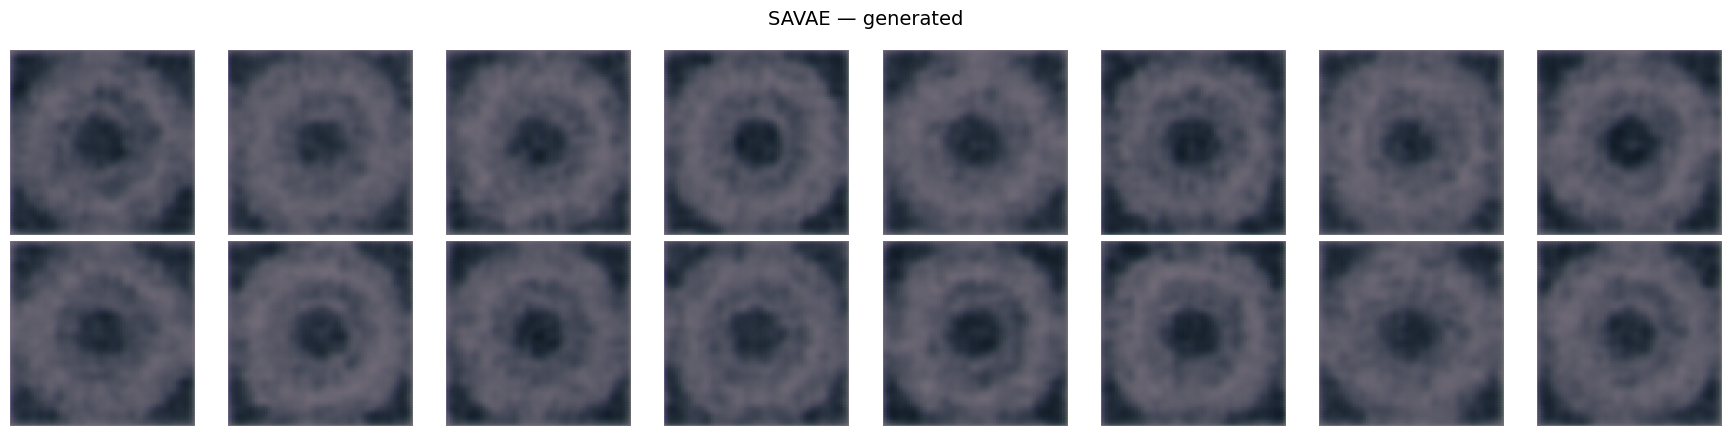

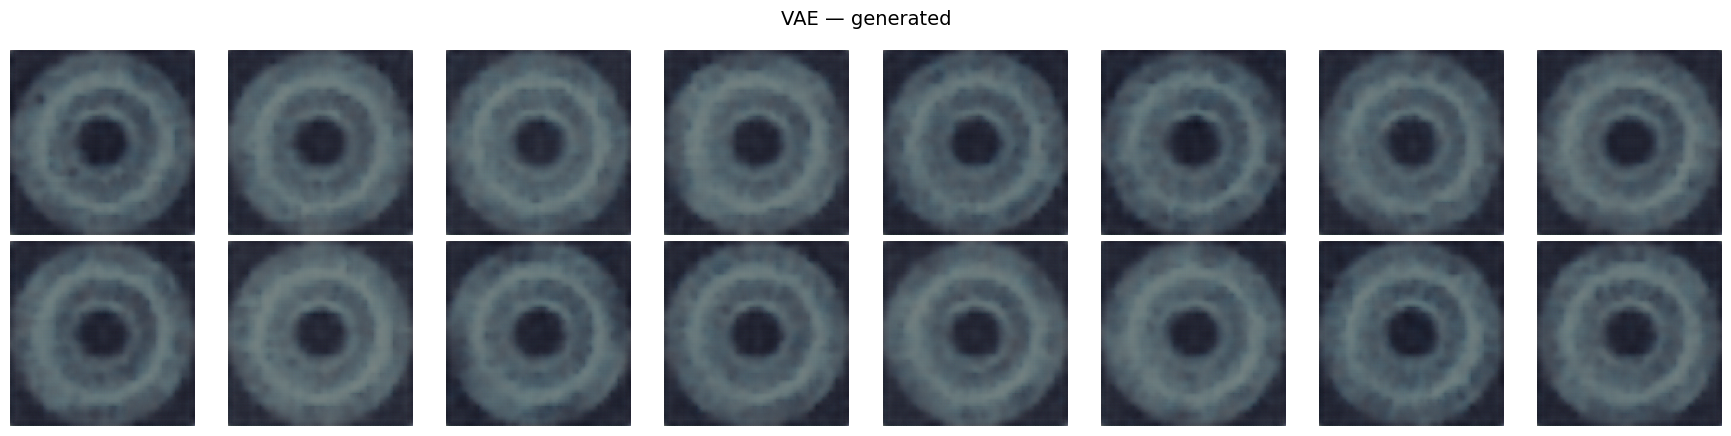

In [57]:
import os, glob, math, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_gallery(dir_path, pattern="*.png", n=32, ncols=8, shuffle=True, title=None, seed=None):
    files = sorted(glob.glob(os.path.join(dir_path, pattern)))
    if not files:
        print(f"No files found in {dir_path} matching {pattern}")
        return
    if shuffle:
        if seed is not None:
            random.seed(seed)
        random.shuffle(files)
    files = files[:n]
    nrows = math.ceil(len(files) / ncols)
    plt.figure(figsize=(ncols*2.2, nrows*2.2))
    for i, f in enumerate(files):
        img = np.array(Image.open(f).convert("RGB"))
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img)
        ax.axis("off")
    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# reproducible
show_gallery("/kaggle/working/outputs/savae_gen_big", n=16, seed=None, title="SAVAE — generated")

# different every run
show_gallery("/kaggle/working/outputs/vae_gen_big", n=16, seed=None, title="VAE — generated")

# show_gallery("/kaggle/working/outputs/ref_good", n=16, seed=None, title="Reference — test/good")


# # generated samples and references
# show_gallery("/kaggle/working/outputs/savae_gen_big", n=16, ncols=8, title="SAVAE — generated")
# show_gallery("/kaggle/working/outputs/vae_gen_big",   n=16, ncols=8, title="VAE — generated")
# show_gallery("/kaggle/working/outputs/ref_good",      n=16, ncols=8, title="Reference — test/good")

# # also show recon/samples grids we saved earlier
# show_gallery("/kaggle/working/outputs", pattern="savae_val_recons.png", n=1, ncols=1, shuffle=False, title="SAVAE recons")
# show_gallery("/kaggle/working/outputs", pattern="vae_val_recons.png",   n=1, ncols=1, shuffle=False, title="VAE recons")
# show_gallery("/kaggle/working/outputs", pattern="dae_val_recons.png",   n=1, ncols=1, shuffle=False, title="DAE recons")
# show_gallery("/kaggle/working/outputs", pattern="savae_samples.png",    n=1, ncols=1, shuffle=False, title="SAVAE sample grid")
# show_gallery("/kaggle/working/outputs", pattern="vae_samples.png",      n=1, ncols=1, shuffle=False, title="VAE sample grid")
# show_gallery("/kaggle/working/outputs", pattern="savae_aleatoric.png",  n=1, ncols=1, shuffle=False, title="SAVAE aleatoric")
# show_gallery("/kaggle/working/outputs", pattern="savae_epistemic.png",  n=1, ncols=1, shuffle=False, title="SAVAE epistemic")

# Generated Data with AR-SAVAE

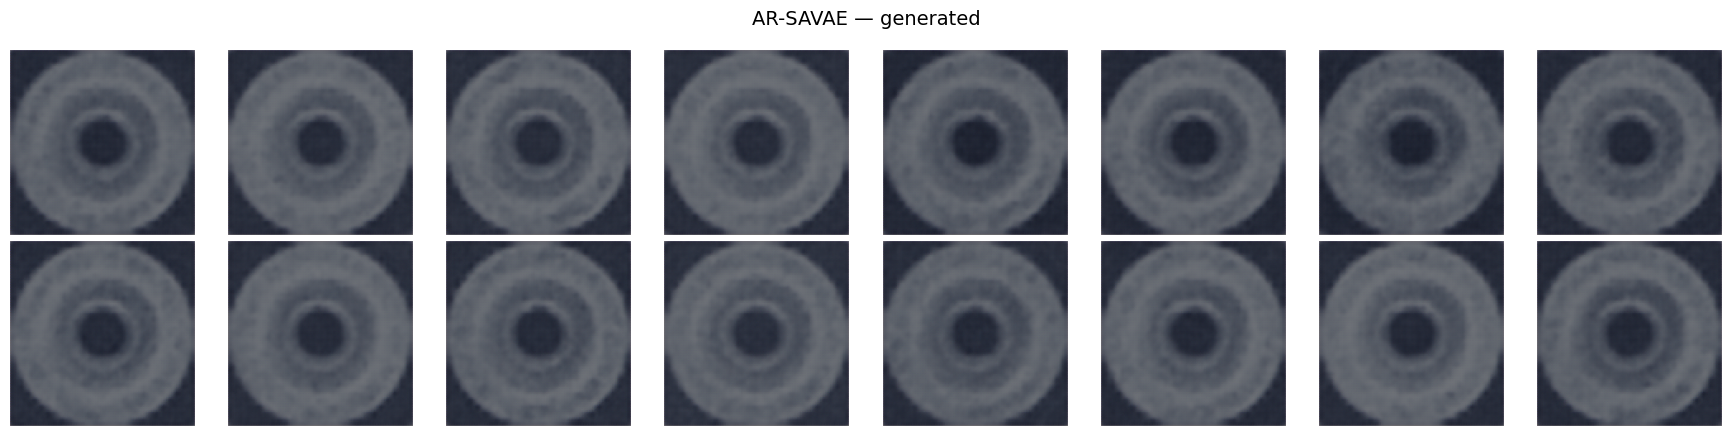

In [65]:
# === Gallery: AR-SAVAE generated images ===
import os, glob, math, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_gallery(dir_path, pattern="*.png", n=32, ncols=8, shuffle=True, title=None, seed=None):
    files = sorted(glob.glob(os.path.join(dir_path, pattern)))
    if not files:
        print(f"No files found in {dir_path} matching {pattern}")
        return
    if shuffle:
        if seed is not None:
            random.seed(seed)
        random.shuffle(files)
    files = files[:n]
    nrows = math.ceil(len(files)/ncols)
    plt.figure(figsize=(ncols*2.2, nrows*2.2))
    for i, f in enumerate(files):
        img = np.array(Image.open(f).convert("RGB"))
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img)
        ax.axis("off")
    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

show_gallery("/kaggle/working/outputs/arsavae_gen_big", n=16, seed=None, title="AR-SAVAE — generated")


In [67]:
import shutil, os, subprocess, sys
from pathlib import Path
from IPython.display import FileLink, display

OUT_DIR = Path("/kaggle/working/outputs")
ZIP_PATH = Path("/kaggle/working/outputs_snapshot.zip")

if not OUT_DIR.exists():
    raise FileNotFoundError(f"{OUT_DIR} does not exist")

# create zip
if ZIP_PATH.exists():
    ZIP_PATH.unlink()
shutil.make_archive(str(ZIP_PATH.with_suffix('')), 'zip', str(OUT_DIR))

# show size + download link
size_mb = ZIP_PATH.stat().st_size / (1024**2)
print(f"Created: {ZIP_PATH} ({size_mb:.2f} MB)")
display(FileLink(str(ZIP_PATH)))

Created: /kaggle/working/outputs_snapshot.zip (233.61 MB)


/kaggle/working/outputs_snapshot.zip